Group members:


-   Ceccon Gioele - 2079425
-   Nardella Gaia - 2091413
-   Renna Pietro
-   Rocca Valerio - 2094861



# Imports

In [55]:
from xml.dom import pulldom
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score
import time 

# Point Generation

We decided to generate 10000 points: 


1.   5000 belong to class 1 
2.   5000 belong to class -1

In total, only 5% of the samples (equally divided among the two classes) have their true labeled assigned. 



In [56]:
n_points = 6000  # change to 10000

In [57]:
def generate_points(n_points=n_points, weights = [0.25, 0.25, 0.25, 0.25]):
    # Define the means and covariance matrices for the four clusters
    cluster_params = [
        {
            'mean': np.array([-2, 0]),
            'cov': np.array([[7, 0], [0, 0.5]])
        },
        {
            'mean': np.array([2, 4]),
            'cov': np.array([[0.5, 0], [0, 4]])
        },
        {
            'mean': np.array([2, 11]),
            'cov': np.array([[7, 0], [0, 0.5]])
        },
        {
            'mean': np.array([-2, 7]),
            'cov': np.array([[0.5, 0], [0, 4]])
        }
    ]

    samples = np.empty((0, 3))

    #giro sui cluster
    for i, cluster in enumerate(cluster_params):
        # Estraggo punti
        sample = np.random.multivariate_normal(cluster['mean'], cluster['cov'], int(n_points*weights[i]))
        # Se i punti sono stati estratti dai primi due cluster, assegno ai punti label 1.
        # Se i punti sono stati estratti dagli altri due cluster, assegno ai punti label -1
        if i==0 or i==1:
            label=1
        elif i==2 or i==3:
            label =-1
        
        # np.full() is a NumPy function that creates a new array of a specified shape and fills it with a given scalar value (label)
        # The axis=1 argument tells np.concatenate() to concatenate the arrays horizontally (i.e., by adding columns), so that the label
        # column is added to the right of the sample array.
        sample = np.concatenate((sample, np.full((sample.shape[0], 1), label)), axis=1)
        #unisco tutti i punti dei 4 cluster in un unico array che per ogni elemento ha [cordinata x, cordinata y, label]
        samples = np.concatenate((samples, sample))
    
    for i in range(len(samples)):
        # dopo ogni 19esimo punto ho un punto di cui so l'etichetta, agli altri setto l'etichetta a zero (si conosce l'etichetta del 5% dei punti)
        if i % 20 != 0.0:
            samples[i][2] = 0

    # Split the samples based on their class label
    unlabeled = samples[samples[:, 2] == 0]
    class1= samples[samples[:, 2] == 1]
    class2 = samples[samples[:, 2] == -1]
    labeled = np.concatenate((class1,class2))

    return unlabeled, class1, class2, labeled  # restituisce una tupla

In [58]:
# Set up parameters for the L shape
mu1 = np.array([-2, -5])
mu2 = np.array([2, -1])
mu3 = np.array([2, 5])
mu4 = np.array([-2, 2])
#mu1 = np.array([-1, -4])
#mu2 = np.array([1, 0])
#mu3 = np.array([1, 4])
#mu4 = np.array([-1, 1])
sigma1 = np.array([[7, 0], [0, 0.5]])
sigma2 = np.array([[0.5, 0], [0, 4]])  # Modified standard deviation for sample 2
sigma3 = np.array([[7, 0], [0, 0.5]])
sigma4 = np.array([[0.5, 0], [0, 4]])  # Modified standard deviation for sample 4
weights = [0.25, 0.25, 0.25, 0.25]

In [59]:
# Generate random points in the L shape using the Bivariate Gaussian Mixture Distribution
samples1 = np.random.multivariate_normal(mu1, sigma1, int(n_points * weights[0]))
samples2 = np.random.multivariate_normal(mu2, sigma2, int(n_points * weights[1]))
samples3 = np.random.multivariate_normal(mu3, sigma3, int(n_points * weights[2]))
samples4 = np.random.multivariate_normal(mu4, sigma4, int(n_points * weights[3]))

In [60]:
# Assign class labels to the samples
class1 = np.concatenate((samples2, samples1))
class1 = np.c_[class1, np.zeros(len(class1))]
count = 0
true_unlab = []
for i in class1:
    if count == 19:
        count = 0
        i[2] = 1
    else: 
      true_unlab.append(1)
    count += 1

class2 = np.concatenate((samples3, samples4))
class2 = np.c_[class2, np.zeros(len(class2))]
count = 0
for i in class2:
    if count == 19:
        count = 0
        i[2] = -1
    else: 
      true_unlab.append(-1)
    count += 1

# Combine the samples of all three classes
all_samples = np.concatenate((class1, class2))

In [61]:
# Split the samples based on their class label
unlabeled_samples = all_samples[all_samples[:, 2] == 0]
class1_samples = all_samples[all_samples[:, 2] == 1]
class2_samples = all_samples[all_samples[:, 2] == -1]

In [62]:
# Labeled matrix
labeled_samples = np.concatenate((class1_samples, class2_samples))

In [63]:
# Assign random label to unlabeled units
random_unlabeled = np.copy(unlabeled_samples)
random_unlabeled[:, 2] = np.random.choice([-1, 1], size=(random_unlabeled.shape[0]), p=[0.5, 0.5])

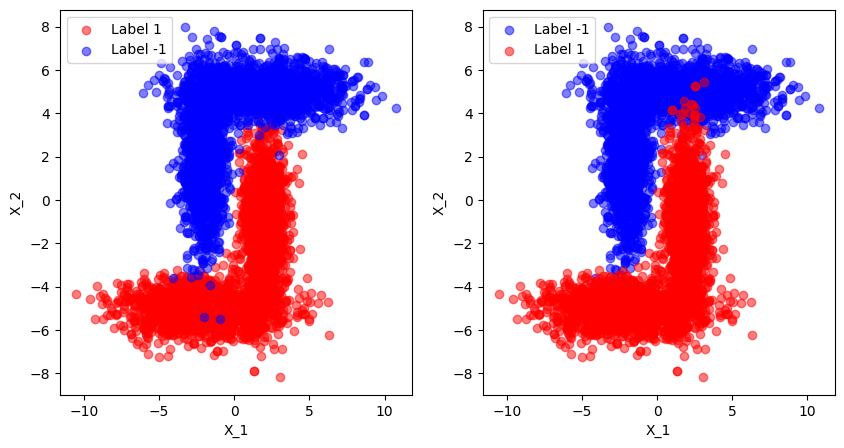

In [64]:
true_samples = np.copy(all_samples)

k = 0
for i in range(len(true_samples)):
  if true_samples[i,2] == 0:
    true_samples[i,2] = true_unlab[k]
    k += 1

positive = true_samples[(true_samples[:, 2] == 1)]  # matrix with unlab samples having true lab 1
negative = true_samples[(true_samples[:, 2] == -1)] # matrix with unlab samples having true lab -1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: positive and negative samples
ax1.scatter(positive[:, 0], positive[:, 1], color='red', alpha=0.5)
ax1.scatter(class1_samples[:, 0], class1_samples[:, 1], color='red', label='Label 1', alpha=0.5)
ax1.scatter(class2_samples[:, 0], class2_samples[:, 1], color='blue', label='Label -1', alpha=0.5)
ax1.scatter(negative[:, 0], negative[:, 1], color='blue', alpha=0.5)

ax1.legend()
ax1.set_xlabel('X_1')
ax1.set_ylabel('X_2')

# Plot 2: negative and positive samples
ax2.scatter(class2_samples[:, 0], class2_samples[:, 1], color='blue', label='Label -1', alpha=0.5)
ax2.scatter(negative[:, 0], negative[:, 1], color='blue', alpha=0.5)
ax2.scatter(positive[:, 0], positive[:, 1], color='red', alpha=0.5)
ax2.scatter(class1_samples[:, 0], class1_samples[:, 1], color='red', label='Label 1', alpha=0.5)

ax2.legend()
ax2.set_xlabel('X_1')
ax2.set_ylabel('X_2')

# Show the plot
plt.show()

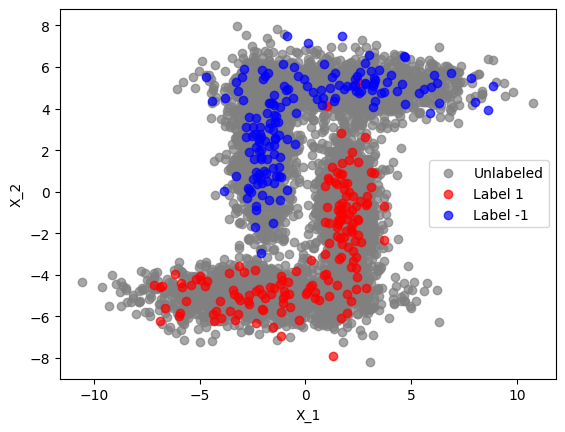

In [65]:
# Plot the samples of each class with a different color and marker
plt.scatter(unlabeled_samples[:, 0], unlabeled_samples[:, 1], color='grey', label='Unlabeled', alpha=0.7)
plt.scatter(class1_samples[:, 0], class1_samples[:, 1], color='red', label='Label 1', alpha=0.7)
plt.scatter(class2_samples[:, 0], class2_samples[:, 1], color='blue', label='Label -1', alpha=0.7)

# Add legend and axis labels
plt.legend()
plt.xlabel('X_1')
plt.ylabel('X_2')

# Show the plot
plt.show()

In [66]:
print(f"There are {len(labeled_samples)} labeled instances: {np.round(((len(labeled_samples)/len(all_samples))*100),1)}% of the total.")

There are 314 labeled instances: 5.2% of the total.


# Similarity function and weights computation

Since the points are drawn from a 2D space, we choose to adopt theinverse multiquadratic kernel as similarity function:

$$ K(x, y) = \frac{1}{\sqrt{c^2 + ||x - y||^2}} $$

In [67]:
def inverse_multiquadratic_kernel(p1, p2, c=0.5):
    """
    Computes the inverse multiquadratic kernel between two 2D points.

    Args:
    p1: A numpy array of shape (2,) containing the first 2D point.
    p2: A numpy array of shape (2,) containing the second 2D point.
    c: A scalar value that controls the strength of the kernel.

    Returns:
    A scalar value representing the inverse multiquadratic kernel between the two points.
    """
    # Compute the Euclidean distance between the points
    dist = np.sqrt(np.sum((p1 - p2) ** 2))

    # Compute the inverse multiquadratic kernel
    kernel = 1.0 / np.sqrt(dist ** 2 + c ** 2)

    return kernel

In [68]:
#def min_max_normalize_matrix(matrix):
#    min_val = np.min(matrix)
#    max_val = np.max(matrix)
#    return (matrix - min_val) / (max_val - min_val)

In [69]:
w = np.zeros((np.shape(unlabeled_samples)[0], np.shape(labeled_samples)[0]))
w_bar = np.zeros((np.shape(unlabeled_samples)[0], np.shape(unlabeled_samples)[0]))

# similarity matrix unlabeled-labeled
for row in range(np.shape(w)[0]):
    for col in range(np.shape(w)[1]):
        #w[row, col] = np.linalg.norm(unlabeled_samples[row, :2] - labeled_samples[col, :2], ord = 2)
        w[row, col] = inverse_multiquadratic_kernel(unlabeled_samples[row, :2],labeled_samples[col, :2])

# similarity matrix unlabeled-unlabeled
for row in range(np.shape(w_bar)[0]):
    for col in range(np.shape(w_bar)[1]):
        #w_bar[row, col] = np.linalg.norm(unlabeled_samples[row, :2] - unlabeled_samples[col, :2], ord = 2)
        w_bar[row, col] = inverse_multiquadratic_kernel(unlabeled_samples[row, :2],unlabeled_samples[col, :2])

In [70]:
#w = min_max_normalize_matrix(w)
#w_bar = min_max_normalize_matrix(w_bar)

# Lipschitz constant

If f is twice continuously differentiable, then the Lipschitz constant can be estimated as the maximum eigenvalue of the Hessian matrix $\nabla^2 f$ at any point in the domain of f. Specifically, the Lipschitz constant L is given by:
$$ L = \|\nabla^2 f(x)\| $$

Thus, we can use the maximum eigenvalue of $\nabla^2 f$ to estimate L.

In this problem, the Hessian matrix is a diagonal matrix positive-definite.

In [71]:
def hessian(w=w, w_bar=w_bar):
  dim = np.shape(unlabeled_samples)[0]
  h = np.zeros((dim,dim))

  for i in range(dim):
    h[i,i] = 2 * (np.sum(w[i,:]) + np.sum(w_bar[i,:]))

  return h


In [72]:
def compute_L(hessian):
  eigenvalues = np.linalg.eigvals(hessian)
  return np.max(np.abs(eigenvalues))

In [73]:
h = hessian()
L = compute_L(h)
print(L)

3831.7019208530583


# Gradient Methods

First of all we define some constants and functions that will be used by the algorithms:

In [ ]:
epsilon = 1e-5      # Threshold for the stopping condition
epochs = 50         # Max number of iterations
check = 5           # Used to retrieve informations about the behavior of the algorithm every check iterations

In [ ]:
# Threshold selector
def threshold_sel(y_lab_norm):
    y_lab_out = np.copy(y_lab_norm)
    y_lab_out[y_lab_out < 0] = -1
    y_lab_out[y_lab_out >= 0] = 1
    
    return y_lab_out

In [ ]:
# Accuracy function
def get_accuracy(y):
  y_out = threshold_sel(y)

  return accuracy_score(true_unlab, y_out)

In [ ]:
# Plot the missclassified and correctly classified units
def miss_plot(unlab_grad, unlab_samples = unlabeled_samples, unlab_true = true_unlab):
  # Output labels
  unlab_labs = threshold_sel(unlab_grad)
  
  # Split in two matrices to plot
  for i in range(np.shape(unlab_samples)[0]):
    unlab_samples[i,2] = unlab_labs[i]
  unlab_true = np.array(unlab_true)

  unlab_samples_tp = unlab_samples[(unlab_samples[:, 2] == 1) & (unlab_samples[:, 2] == unlab_true)]
  unlab_samples_tn = unlab_samples[(unlab_samples[:, 2] == -1) & (unlab_samples[:, 2] == unlab_true)]
  unlab_samples_fp = unlab_samples[(unlab_samples[:, 2] == 1) & (unlab_samples[:, 2] != unlab_true)]
  unlab_samples_fn = unlab_samples[(unlab_samples[:, 2] == -1) & (unlab_samples[:, 2] != unlab_true)]
  
  # Plot the samples of each class with a different color and marker
  plt.scatter(unlab_samples_tp[:, 0], unlab_samples_tp[:, 1], color='red', label='True 1', alpha=0.7)
  plt.scatter(unlab_samples_tn[:, 0], unlab_samples_tn[:, 1], color='blue', label='True -1', alpha=0.7)
  plt.scatter(unlab_samples_fp[:, 0], unlab_samples_fp[:, 1], color='orange', label='False 1', alpha=0.7)
  plt.scatter(unlab_samples_fn[:, 0], unlab_samples_fn[:, 1], color='cyan', label='False -1', alpha=0.7)

  # Add legend and axis labels
  plt.legend()
  plt.xlabel('X_1')
  plt.ylabel('X_2')

  # Show the plot
  return(plt.show())


In [ ]:
# Plot accuracy vs epochs
def acc_epochs_plot(result_list, check=check):
  #acc_list = np.copy(result_list)
  epochs_array = np.arange(0, check * len(result_list), check)
  
  plt.plot(epochs_array, result_list, marker = ".")

  # Set the plot title and labels
  plt.title('Accuracy vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

In [ ]:
# Plot accuracy vs time
def acc_time_plot(result_list, time_list):
  plt.plot(time_list, result_list, marker = ".")

  # Set the plot title and labels
  plt.title('Accuracy vs Time')
  plt.xlabel('Elapsed Time (seconds)')
  plt.ylabel('Accuracy')


## Gradient Descent

In [ ]:
def gradient(lab_samples, unlab_samples, w=w, w_bar=w_bar):
    grads = []
    for j in range(np.shape(unlab_samples)[0]):
        grad = 0
        for i in range(np.shape(lab_samples)[0]):
            grad += 2 * w[j][i] * (unlab_samples[j][2] - lab_samples[i][2])
        for i in range(np.shape(unlab_samples)[0]):
            grad += w_bar[j][i] * (unlab_samples[j][2] - unlab_samples[i][2])
        grads.append(grad) #/ (np.shape(lab_samples)[0] + np.shape(unlab_samples)[0])) #GRADIENT+NORMALIZATION
    return np.array(grads)

In [ ]:
def gradient_descent(lab_samples, unlab_samples, alpha=1/L, epochs=epochs, epsilon=epsilon, check=check):
    y_lab = np.copy(unlab_samples)

    acc_list = []
    time_list = []

    start_time = time.time()

    for i in range(epochs):
        grads = gradient(lab_samples, y_lab)

        norm = np.linalg.norm(grads)
        if  norm < epsilon:
          print(f"The norm of the gradient at iteration {i} is: {norm}") 
          break

        y_lab[:,2] -= alpha * grads
        

        if(i % check == 0):
          print(f"The norm of the gradient at iteration {i} is: {norm}")

          acc_list.append(get_accuracy(y_lab[:,2]))

          elapsed_time = time.time() - start_time
          time_list.append(elapsed_time)

    return y_lab[:,2], np.array(acc_list), np.array(time_list)

In [ ]:
check_gd = 2    # Customzied check constant for the basic GD algorithm

In [ ]:
%%time
y_lab_gd, acc_list_gd, time_list_gd = gradient_descent(labeled_samples, random_unlabeled, check = check_gd)

print(f"\nAccuracy for Gradient Descent: {get_accuracy(y_lab_gd)}")

print("\nNumber of 1 in Gradient Descent {}".format(np.sum(threshold_sel(y_lab_gd) == 1) / len(y_lab_gd)))
print("Number of -1 in Gradient Descent {}\n".format(np.sum(threshold_sel(y_lab_gd) == -1) / len(y_lab_gd)))


The norm of the gradient at iteration 0 is: 122803.56365776718
The norm of the gradient at iteration 2 is: 39018.47163342734
The norm of the gradient at iteration 4 is: 13757.542528735237
The norm of the gradient at iteration 6 is: 5520.17077177072
The norm of the gradient at iteration 8 is: 2533.080982033923
The norm of the gradient at iteration 10 is: 1301.3678310892776
The norm of the gradient at iteration 12 is: 725.3437626036912
The norm of the gradient at iteration 14 is: 427.3960821408075
The norm of the gradient at iteration 16 is: 261.81188102670836
The norm of the gradient at iteration 18 is: 165.11464003581847
The norm of the gradient at iteration 20 is: 106.660679425857
The norm of the gradient at iteration 22 is: 70.45630464402721
The norm of the gradient at iteration 24 is: 47.65867933252519
The norm of the gradient at iteration 26 is: 33.15834837333686
The norm of the gradient at iteration 28 is: 23.89176713417799
The norm of the gradient at iteration 30 is: 17.956740073

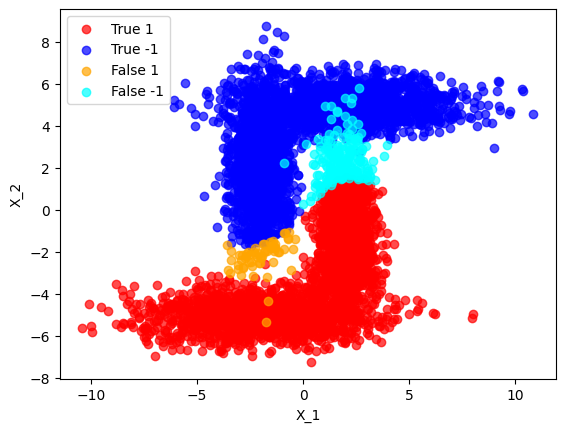

In [ ]:
miss_plot(y_lab_gd)

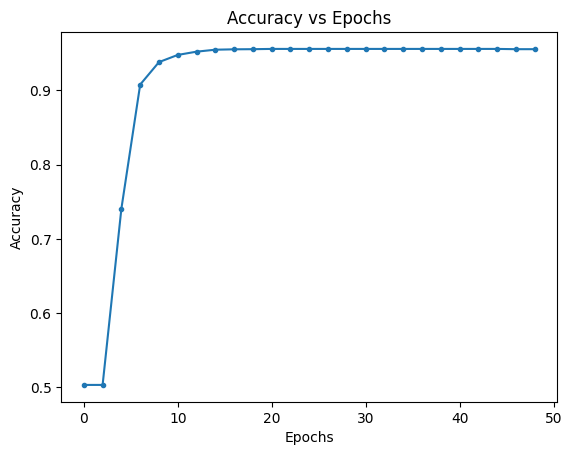

In [ ]:
acc_epochs_plot(acc_list_gd, check = check_gd)

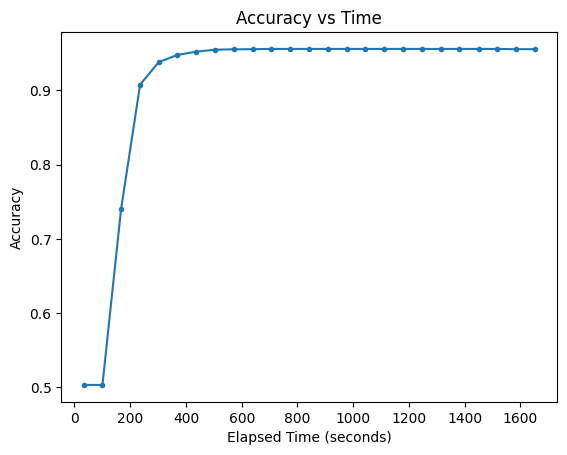

In [ ]:
acc_time_plot(acc_list_gd, time_list_gd)

## Randomized BCGD

In [ ]:
def rand_gradient(lab_samples, unlab_samples, w=w, w_bar=w_bar):
    grads = np.zeros(np.shape(unlab_samples)[0])
    j = np.random.randint(0, np.shape(unlab_samples)[0])
    j = int(j)
    grad = 0
    for i in range(np.shape(lab_samples)[0]):
        grad += 2 * w[j][i] * (unlab_samples[j][2] - lab_samples[i][2])
    for i in range(np.shape(unlab_samples)[0]):
        grad += w_bar[j][i] * (unlab_samples[j][2] - unlab_samples[i][2])
    grads[j] = grad  # / (np.shape(lab_samples)[0] + np.shape(unlab_samples)[0])
    return grads

In [ ]:
def rand_bcgd(lab_samples, unlab_samples, alpha=1/L, epochs=epochs, epsilon=epsilon, check=check):
    y_lab = np.copy(unlab_samples)

    acc_list = []
    time_list = []

    start_time = time.time()

    for i in range(epochs):
        grads = rand_gradient(lab_samples, y_lab)

        norm = np.linalg.norm(grads)
        if  norm < epsilon: 
          print(f"The norm of the gradient at iteration {i} is: {norm}")
          break

        y_lab[:, 2] -= alpha * grads

        if(i % check == 0):
          print(f"The norm of the gradient at iteration {i} is: {norm}")
          acc_list.append(get_accuracy(y_lab[:,2]))
          elapsed_time = time.time() - start_time
          time_list.append(elapsed_time)

    return y_lab[:,2], acc_list, time_list

In [ ]:
epochs_random = 200000  # Customzied epochs constant for the Randomized BCGD algorithm
check_random = 200     # Customzied check constant for the Randomized BCGD algorithm

In [ ]:
%%time
y_lab_rand_bcgd, acc_list_rand_bcgd, time_list_rand_bcgd = rand_bcgd(labeled_samples, random_unlabeled, epochs = epochs_random, check = check_random)

print(f"\nAccuracy for Randomized BCGD: {get_accuracy(y_lab_rand_bcgd)}")

print("\nFrequency of 1 in Randomized BCGD {}".format(np.sum(threshold_sel(y_lab_rand_bcgd) == 1) / len(y_lab_rand_bcgd)))
print("Frequency of -1 in Randomized BCGD {}\n".format(np.sum(threshold_sel(y_lab_rand_bcgd) == -1) / len(y_lab_rand_bcgd)))


In [ ]:
miss_plot(y_lab_rand_bcgd)

In [ ]:
acc_epochs_plot(acc_list_rand_bcgd, check = check_random)

In [ ]:
acc_time_plot(acc_list_rand_bcgd, time_list_rand_bcgd)

## Gauss-Southwell BCGD

In [105]:
def max_gradient(lab_samples, unlab_samples):
  grad = gradient(lab_samples, unlab_samples)
  j = np.argmax(np.abs(grad))
  grads = np.zeros(np.shape(unlab_samples)[0])
  grads[j] = grad[j]
  return grads

In [106]:
def gs_gradient(lab_samples, unlab_samples, index, step_size, old_gradient):
  
  update = np.zeros(len(unlab_samples))
  grad = 0
  for i in range(np.shape(lab_samples)[0]):
    grad += 2 * w[index][i] * (unlab_samples[index][2] - lab_samples[i][2])
  for i in range(np.shape(unlab_samples)[0]):
    grad += w_bar[index][i] * (unlab_samples[index][2] - unlab_samples[i][2])
  
  update[index] = grad

  unlab_samples[:, 2] = -step_size * update

  grad = 0
  for i in range(np.shape(lab_samples)[0]):
    grad += 2 * w[index][i] * (unlab_samples[index][2] - lab_samples[i][2])
  for i in range(np.shape(unlab_samples)[0]):
    grad += w_bar[index][i] * (unlab_samples[index][2] - unlab_samples[i][2])
  
  old_gradient[index] = grad 


  return unlab_samples[:,2], old_gradient

In [107]:
def gs_bcgd(lab_samples, unlab_samples, alpha=1/L, epochs=epochs, epsilon=epsilon, check=check):
    y_lab = np.copy(unlab_samples)

    acc_list = []
    time_list = []

    start_time = time.time()

    grad = gradient(lab_samples, unlab_samples)

    for i in range(epochs):

      norm = np.linalg.norm(grad)
      if  norm < epsilon:
        print(f"The norm of the gradient at iteration {i} is: {norm}") 
        break
      
      j = np.argmax(np.abs(grad))

      y_lab[:, 2], grad = gs_gradient(lab_samples, y_lab, j, alpha, grad)

      if(i % check == 0):
        print(f"The norm of the gradient at iteration {i} is: {norm}")
        acc_list.append(get_accuracy(y_lab[:,2]))
        elapsed_time = time.time() - start_time
        time_list.append(elapsed_time)

    return y_lab[:,2], acc_list, time_list

In [108]:
epochs_gs = 200000  # Customzied epochs constant for the Randomized BCGD algorithm
check_gs = 200     # Customzied check constant for the Randomized BCGD algorithm

In [109]:
%%time
y_lab_gs_bcgd, y_list_gs_bcgd, time_list_gs_bcgd = gs_bcgd(labeled_samples, random_unlabeled, epochs = epochs_gs, check = check_gs)

print(f"\nAccuracy for Gauss-Southwell BCGD: {get_accuracy(y_lab_gs_bcgd)}")

print("\nFrequency of 1 in Gauss Sauthwell BCGD {}".format(np.sum(threshold_sel(y_lab_gs_bcgd) == 1) / len(y_lab_gs_bcgd)))
print("Frequency of -1 in Gauss Sauthwell BCGD {}\n".format(np.sum(threshold_sel(y_lab_gs_bcgd) == -1) / len(y_lab_gs_bcgd)))

The norm of the gradient at iteration 0 is: 122857.84909814839
The norm of the gradient at iteration 200 is: 119452.78305523255
The norm of the gradient at iteration 400 is: 116174.93613226632
The norm of the gradient at iteration 600 is: 112969.96650701514
The norm of the gradient at iteration 800 is: 109808.03925918227
The norm of the gradient at iteration 1000 is: 106635.40084675187
The norm of the gradient at iteration 1200 is: 103434.86733083517
The norm of the gradient at iteration 1400 is: 100206.65403746473
The norm of the gradient at iteration 1600 is: 96961.35138739912
The norm of the gradient at iteration 1800 is: 93706.25094612587
The norm of the gradient at iteration 2000 is: 90430.49669772713
The norm of the gradient at iteration 2200 is: 87099.76432102013
The norm of the gradient at iteration 2400 is: 83705.93303099755
The norm of the gradient at iteration 2600 is: 80245.65888638514
The norm of the gradient at iteration 2800 is: 76708.34642547673
The norm of the gradient

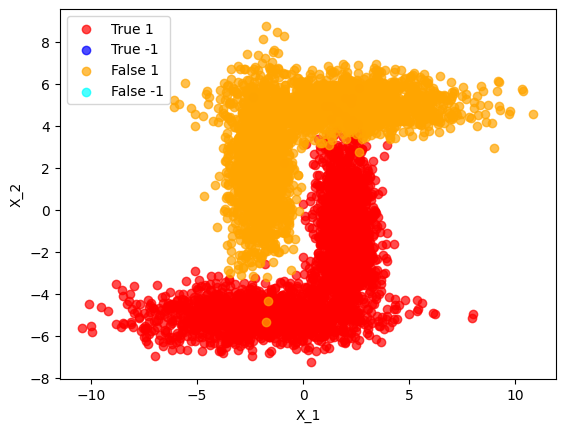

In [110]:
miss_plot(y_lab_gs_bcgd)

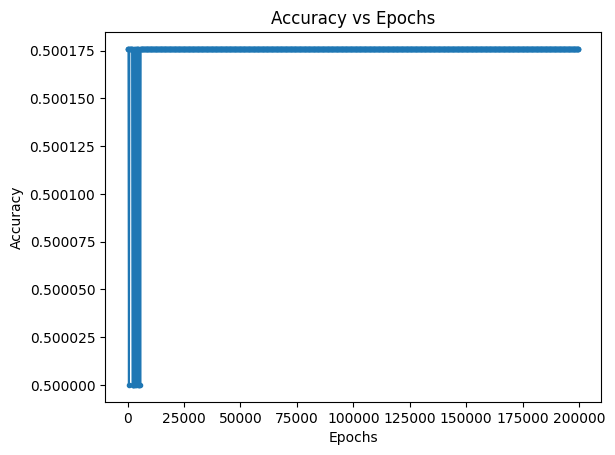

In [111]:
acc_epochs_plot(y_list_gs_bcgd, check = check_gs)